<a href="https://colab.research.google.com/github/hamidbekam9193-ui/Lectures/blob/main/DL/M3_2_Transformermodels_NLU_v4_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The main questions that we aim to answer in this lecture are:

1. What are the main challenges of RNNs and LSTMs?
2. Attention Mechanisms
      - How do attention mechanisms solve the challenges associated with RNNs and LSTMs?
      - What is the fundamental idea behind the attention mechanism?
      - How does the attention mechanism function?
3. What is the Transformer model architecture, and how does it differ from encoder-decoder models?
4. What is text embedding?
5. How can one train a Transformer model to compute embeddings?
6. What are the differences between word embeddings and sentence embeddings?




## How Do Attention Mechanisms Solve RNN and LSTM Challenges?

![](https://miro.medium.com/v2/resize:fit:1280/1*w2OJ4jfjxmlcqu6k4BdgrA.gif)

| RNN/LSTM Problems                          | How Attention Helps                                   |
|--------------------------------------------|------------------------------------------------------|
| Hard to learn from long steps back         | Looks directly at important past information         |
| Training can be unstable                   | Uses special techniques to stay stable (gradient clipping or other techniques)               |
| Slow with long sentences                   | Works on whole sentences at once, so it's faster     |
| Struggles with very distant info           | Can easily use info from anywhere in the sentence    |
| Can't always use all relevant info         | Chooses which info to use at each step               |
| Can be heavy on memory                     | Lighter on memory, no need to remember every step    |
| Hard to see why it made a decision         | Can show which words affected the decision           |


# What is text embedding?

Text embedding is a representation of text in the form of vectors. The main goal of embedding is to capture the semantic meaning of the text in a way that reflects the context and usage of words or phrases. In machine learning, embeddings are used to convert text into a continuous vector space where similar words have similar representations, making it easier for models to understand and process language.

Let's try checking the embeddings of words.


[Embeddings Projector](https://projector.tensorflow.org/)

In general all types of text embeddings approaches can be grouped into two categorizes namely word enbeddings and sentence embeddings.

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/word_embeddings.png)

In the first step, we will explore BERT models. Afterward, we will investigate the SBERT approach to generating sentence embeddings.



![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/sentence_embeddings.png)

To begin with, it's essential to grasp the distinctions between Bi-Encoders and Cross-Encoders.

- Bi-Encoders generate a sentence embedding for a specific sentence. In this process, sentences A and B are independently fed into a BERT model, resulting in sentence embeddings u and v, respectively. These embeddings can then be evaluated against each other using cosine similarity.

- Cross-Encoders take both sentences at the same time and input them into the Transformer model. This model then yields a score ranging from 0 to 1 that reflects the degree of similarity between the two input sentences.


![](https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/docs/img/Bi_vs_Cross-Encoder.png)

Unlike Bi-Encoders, Cross-Encoders do not create sentence embeddings. Additionally, it's not possible to input sentences into a Cross-Encoder one at a time.

In [ ]:
!pip install -U sentence-transformers --q

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.',
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences, convert_to_tensor=True)

#Print the embeddings
for sentence, embedding in zip(sentences[:1], embeddings[:1]):
    print("Sentence:", sentence)
    print("Embedding shape:", embedding.shape)
    print("")

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sentence: This framework generates embeddings for each input sentence
Embedding shape: torch.Size([384])



In [ ]:
from transformers import BertTokenizer, BertModel
import torch
# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the sentence
sentence = 'This framework generates embeddings for each input sentence'
inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)

# Get the token IDs (input to the model)
input_ids = inputs['input_ids']

# Forward pass through BERT to get the embeddings
with torch.no_grad():
    outputs = model(input_ids)

# The last_hidden_state is the embeddings for the last layer
# It has shape [batch_size, sequence_length, hidden_size], where hidden_size is 768 for BERT base
embeddings = outputs.last_hidden_state.squeeze(0)  # Remove the batch dimension
embeddings.shape

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


torch.Size([13, 768])

Remember that BERT adds special tokens like [CLS] at the start and [SEP] at the end of the sentence. If you're interested in word-level embeddings, you would ignore these special tokens.

# Exercise 1

Calculate embeddings for "The bank of the river" and "Money in the bank" using SBERT and BERT, and show the embeddings for each sentence?

# How can trian a transformer model to compute embeddings?

There are two different types of training for Transformer models: **pre-training** and **fine-tuning**.


![](https://docs.graphcore.ai/projects/bert-training/en/latest/_images/training-tuning-inference.png)

For Transformer models that use a **Masked Language Model (MLM)** approach, such as BERT, the training process is specialized to handle the unique challenges of understanding language in a bidirectional context. Here's an overview of the training approaches for MLM-based Transformer models:

## Pre-training

MLM-based models are typically trained in two stages, with pre-training being the first:

> - **Masked Language Modeling**: In this core pre-training task, a certain percentage of the input tokens are replaced with a [MASK] token, and the model must predict the original token. This trains the model to understand context and to use surrounding words to fill in blanks. For example:
      Original Sentence: "The quick brown fox jumps over the lazy dog."
      MLM Input: "The quick brown [MASK] jumps over the lazy dog."
      Model's Task: Predict the word "fox" to replace [MASK].
> - **Next Sentence Prediction (NSP)**: In the case of BERT, along with the MLM task, the model is also trained on a binary classification task to predict whether two sentences follow each other in the original text. This helps the model learn relationships between sentences. For example:
      Sentence A: "The quick brown fox jumps over the lazy dog."
      Sentence B: "It then swiftly ran up the hill."
      Sentence B: "Oranges are rich in vitamin C."

During pre-training, the model is trained on a large, diverse corpus of text to develop a broad understanding of language. The choice of corpus is crucial — it needs to be large and varied enough to ensure that the model can learn a wide range of linguistic patterns and structures.

## Fine-tuning

Once pre-trained, the model can be fine-tuned on specific downstream tasks:

> - **Supervised Fine-tuning**: Here, the pre-trained model is fine-tuned on a smaller, labeled dataset for tasks such as sentiment analysis, named entity recognition, or question answering. The fine-tuning adapts the model to the specificities of the task at hand.
> - **Task-specific Inputs**: For fine-tuning, the input format is often adapted to the specific task. For instance, for question answering, the input may be structured as "[QUESTION] [SEP] [CONTEXT]" where [SEP] is a special token that separates the question from the context passage.
> - **Output Layer**: During fine-tuning, a task-specific output layer is often added on top of the pre-trained model. For example, for classification tasks, a softmax layer is added to output probability distributions over classes.

### Let's check the architecture of BERT!

![](https://vitalflux.com/wp-content/uploads/2023/08/BERT-base-BERT-Large-neural-network-architectures.png)

### Let's see how BERT has been trianed!

![](https://360digit.b-cdn.net/assets/admin/ckfinder/userfiles/images/blog/11-05-2021/11-05-2021(a)/image4.jpg)

In [ ]:
!pip install transformers --q

In [ ]:
from transformers import BertTokenizer, BertModel

# Initialize the tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize the sentence
sentence = 'The bank of the river.'
inputs = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)

# Get the token IDs (input to the model)
input_ids = inputs['input_ids']

# Forward pass through BERT to get the embeddings
with torch.no_grad():
    outputs = model(input_ids)

# The last_hidden_state is the embeddings for the last layer
# It has shape [batch_size, sequence_length, hidden_size], where hidden_size is 768 for BERT base
embeddings = outputs.last_hidden_state.squeeze(0)  # Remove the batch dimension


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
embeddings.shape

torch.Size([8, 768])

In [ ]:
# Tokenize the sentence
word = 'Money'
inputs = tokenizer(word, return_tensors="pt", add_special_tokens=True)

# Get the token IDs (input to the model)
input_ids = inputs['input_ids']

# Forward pass through BERT to get the embeddings
with torch.no_grad():
    outputs = model(input_ids)

# The last_hidden_state is the embeddings for the last layer
# It has shape [batch_size, sequence_length, hidden_size], where hidden_size is 768 for BERT base
embeddings_money = outputs.last_hidden_state.squeeze(0)

In [ ]:
# Tokenize the sentence
word = 'bank'
inputs = tokenizer(word, return_tensors="pt", add_special_tokens=True)

# Get the token IDs (input to the model)
input_ids = inputs['input_ids']

# Forward pass through BERT to get the embeddings
with torch.no_grad():
    outputs = model(input_ids)

# The last_hidden_state is the embeddings for the last layer
# It has shape [batch_size, sequence_length, hidden_size], where hidden_size is 768 for BERT base
embeddings_bank = outputs.last_hidden_state.squeeze(0)

In [ ]:
embeddings_money

tensor([[-0.1481,  0.2090, -0.1501,  ..., -0.1920,  0.0203,  0.2159],
        [-0.3662, -0.0070, -0.2179,  ..., -0.1550,  0.3773, -0.2120],
        [ 0.8849,  0.1065, -0.2914,  ...,  0.0712, -0.7623, -0.1953]])

Remember that BERT adds special tokens like [CLS] at the start and [SEP] at the end of the sentence. If you're interested in word-level embeddings, you would ignore these special tokens.

In [ ]:
embeddings_all = torch.cat([embeddings[1:6], embeddings_money[2:3], embeddings_bank[2:3]], dim=0)

In [ ]:
embeddings_all.shape

torch.Size([7, 768])

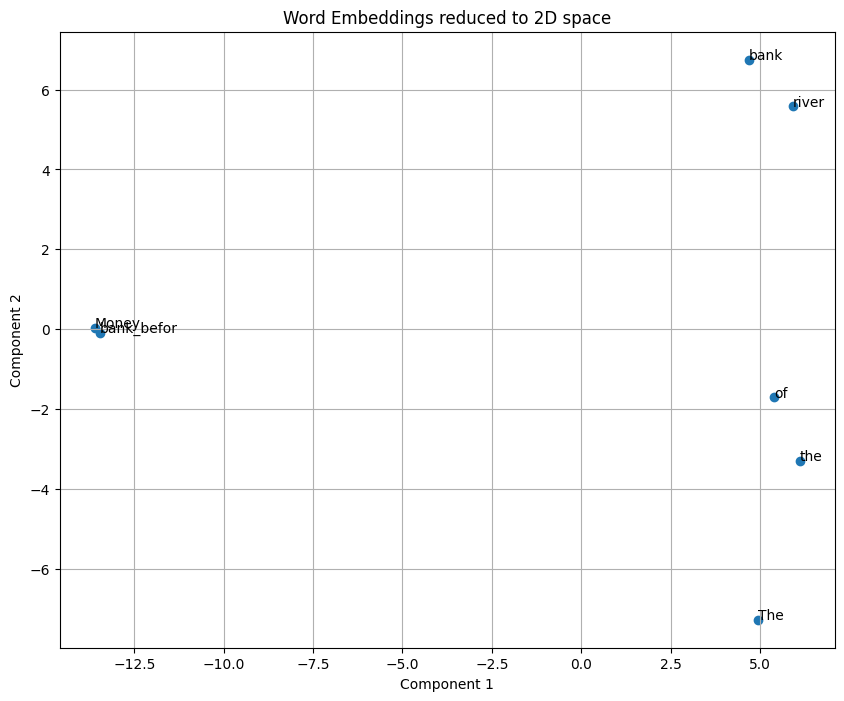

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a PCA object to reduce to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings using PCA
reduced_embeddings = pca.fit_transform(embeddings_all)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# Annotate the points with the words
words = ["The","bank", "of", "the", "river", "Money", "bank_befor"]

for i, word in enumerate(words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Word Embeddings reduced to 2D space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


![](https://media.arxiv-vanity.com/render-output/7086622/bert_pretraining.png)

# Exercise 2


Calculate embeddings for "Money in the bank" using BERT, and show the embeddings for each word?



Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
embeddings.shape

torch.Size([7, 768])

In [ ]:
embeddings_river

tensor([[-0.1796,  0.1017, -0.1155,  ..., -0.2630, -0.0023,  0.3129],
        [ 0.1921,  0.0450, -0.6366,  ..., -0.1717, -0.1990, -0.9993],
        [ 0.8286,  0.1435, -0.4818,  ..., -0.0592, -0.7818, -0.4517]])

In [ ]:
embeddings.shape

torch.Size([7, 768])

In [ ]:
embeddings

tensor([[-0.4430,  0.0079, -0.4375,  ..., -0.3845,  0.1172,  0.4428],
        [ 0.4349, -0.5743, -0.6029,  ..., -0.2938,  0.3898,  0.3591],
        [-0.9434, -0.7637, -0.5412,  ...,  0.0263, -0.1928,  0.1675],
        ...,
        [ 0.2603, -0.7144, -0.1704,  ..., -0.5636, -0.0085, -0.1536],
        [-0.3396, -0.6490, -0.3504,  ...,  0.6894,  0.2251, -0.3824],
        [ 0.8553,  0.0462, -0.3684,  ...,  0.1121, -0.5816, -0.1792]])

In [ ]:
embeddings[1:5]

tensor([[ 0.4349, -0.5743, -0.6029,  ..., -0.2938,  0.3898,  0.3591],
        [-0.9434, -0.7637, -0.5412,  ...,  0.0263, -0.1928,  0.1675],
        [-0.4806, -0.7833, -0.5646,  ...,  0.0526,  0.3938, -0.1321],
        [ 0.2603, -0.7144, -0.1704,  ..., -0.5636, -0.0085, -0.1536]])

In [ ]:
embeddings_all = torch.cat([embeddings[1:5], embeddings_river[2:3], embeddings_bank[2:3], embeddings_money[2:3]], dim=0)

In [ ]:
embeddings_all.shape

torch.Size([7, 768])

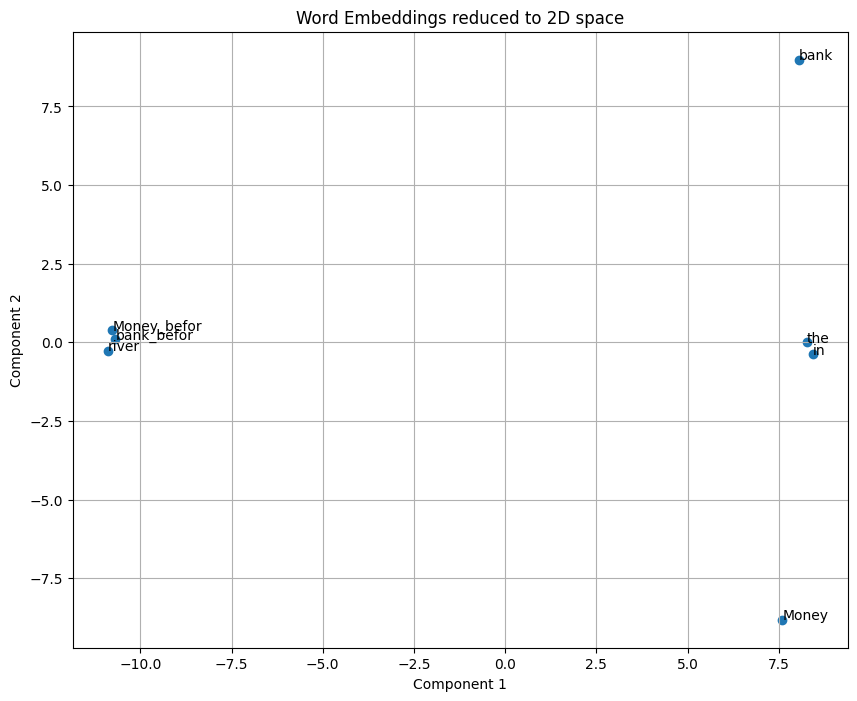

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Create a PCA object to reduce to 2 dimensions
pca = PCA(n_components=2)

# Fit and transform the embeddings using PCA
reduced_embeddings = pca.fit_transform(embeddings_all)

# Plot the reduced embeddings
plt.figure(figsize=(10, 8))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1])

# Annotate the points with the words
words = ["Money", "in", "the", "bank", "river","bank_befor", "Money_befor"]

for i, word in enumerate(words):
    plt.annotate(word, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]))

plt.title('Word Embeddings reduced to 2D space')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.grid(True)
plt.show()


In [ ]:
print(model)

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 109,482,240
Trainable parameters: 109,482,240


In [ ]:
for name, p in model.named_parameters():
    print(name, p.numel())


embeddings.word_embeddings.weight 23440896
embeddings.position_embeddings.weight 393216
embeddings.token_type_embeddings.weight 1536
embeddings.LayerNorm.weight 768
embeddings.LayerNorm.bias 768
encoder.layer.0.attention.self.query.weight 589824
encoder.layer.0.attention.self.query.bias 768
encoder.layer.0.attention.self.key.weight 589824
encoder.layer.0.attention.self.key.bias 768
encoder.layer.0.attention.self.value.weight 589824
encoder.layer.0.attention.self.value.bias 768
encoder.layer.0.attention.output.dense.weight 589824
encoder.layer.0.attention.output.dense.bias 768
encoder.layer.0.attention.output.LayerNorm.weight 768
encoder.layer.0.attention.output.LayerNorm.bias 768
encoder.layer.0.intermediate.dense.weight 2359296
encoder.layer.0.intermediate.dense.bias 3072
encoder.layer.0.output.dense.weight 2359296
encoder.layer.0.output.dense.bias 768
encoder.layer.0.output.LayerNorm.weight 768
encoder.layer.0.output.LayerNorm.bias 768
encoder.layer.1.attention.self.query.weight 5898

> **nn.Embedding** in PyTorch is like a large lookup table that maps each unique word or token in your vocabulary to a high-dimensional vector. Imagine it as a dictionary, but instead of giving you the definition of a word, it gives you a list of numbers that represent that word in a space where similar words are closer together.

# Tokenizers (PyTorch)

In [ ]:
tokenized_text = "The bank of the river".split()
print(tokenized_text)

['The', 'bank', 'of', 'the', 'river']


In [ ]:
tokenizer("The bank of the river")

{'input_ids': [101, 1996, 2924, 1997, 1996, 2314, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

![](https://medium.com/@nubyra/parameter-efficient-fine-tuning-peft-of-bert-base-model-to-predict-medical-diagnosis-5086a1828f4b)

![](https://raw.githubusercontent.com/hamidb201214-svg/Lectures/refs/heads/patch-1/DL/BERT%202019%20Position%20Embeddings.png)

In [ ]:
tokenizer.save_pretrained("directory_on_my_computer")

('directory_on_my_computer/tokenizer_config.json',
 'directory_on_my_computer/tokenizer.json')

In [ ]:
sentence_1 = "The bank of the river."
tokens = tokenizer.tokenize(sentence_1)

print(tokens)

['the', 'bank', 'of', 'the', 'river', '.']


In [ ]:
ids = tokenizer.convert_tokens_to_ids(tokens)

print(ids)

[1996, 2924, 1997, 1996, 2314, 1012]


In [ ]:
decoded_string = tokenizer.decode([1996, 2924, 1997, 1996, 2314, 1012])
print(decoded_string)

the bank of the river.


In [ ]:
len(tokenizer.vocab)

30522

![](https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ElJbBlCQhiWR3XutdLPMNg.png)

In [ ]:
tokenizer.convert_ids_to_tokens(1996)

'the'

# Exercise 3

Check the token IDs for 'Money in the bank'

## Building the Vocabulary

In [ ]:
sentence_1 = 'The bank of the river'
sentence_2 = 'Money in the bank'

In [ ]:
import torch
import torch.nn as nn

# Step 1: Create a vocabulary. Normally you'd want a large corpus to create this.
vocab = {'<pad>': 0, 'The': 1, 'bank': 2, 'of': 3, 'river': 4}
vocab_size = len(vocab)  # This will be the number of rows in the embedding matrix.
embedding_dim = 2  # You can choose the size of the embeddings.

# Step 2: Convert the sentence "The bank of river" to indices.
sentence = "The bank of river"
indices = [vocab[word] for word in sentence.split()]

# Step 3: Create the embedding layer.
embedding_layer = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)

# Step 4: Use the embedding layer to get embeddings for the indices.
# Convert indices list to a tensor.
indices_tensor = torch.LongTensor(indices)

# Get embeddings for indices.
embeddings = embedding_layer(indices_tensor)

print(embeddings)  # This will print out the embeddings for each word in the sentence.

tensor([[-0.2545, -0.0666],
        [-0.2007, -1.5174],
        [ 0.6848,  0.5870],
        [ 0.3273,  1.9577]], grad_fn=<EmbeddingBackward0>)


In [ ]:
embeddings.shape

torch.Size([4, 2])

# Architectures vs. Checkpoints

As we dive into Transformer models in this course, you’ll see mentions of architectures and checkpoints as well as models. These terms all have slightly different meanings:

- Architecture: This is the skeleton of the model — the definition of each layer and each operation that happens within the model.
- Checkpoints: These are the weights that will be loaded in a given architecture.
- Model: This is an umbrella term that isn’t as precise as “architecture” or “checkpoint”: it can mean both. This course will specify architecture or checkpoint when it matters to reduce ambiguity.

For example, BERT is an architecture while bert-base-cased, a set of weights trained by the Google team for the first release of BERT, is a checkpoint. However, one can say “the BERT model” and “the bert-base-cased model.”

![](https://raw.githubusercontent.com/aaubs/ds-master/main/data/Images/transformermodel_architecture.png)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def getPositionEncoding(seq_len, d, n=10000):
    P = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            P[k, 2*i] = np.sin(k/denominator)
            P[k, 2*i+1] = np.cos(k/denominator)
    return P

P = getPositionEncoding(seq_len=4, d=4, n=100)
print(P)

[[ 0.          1.          0.          1.        ]
 [ 0.84147098  0.54030231  0.09983342  0.99500417]
 [ 0.90929743 -0.41614684  0.19866933  0.98006658]
 [ 0.14112001 -0.9899925   0.29552021  0.95533649]]


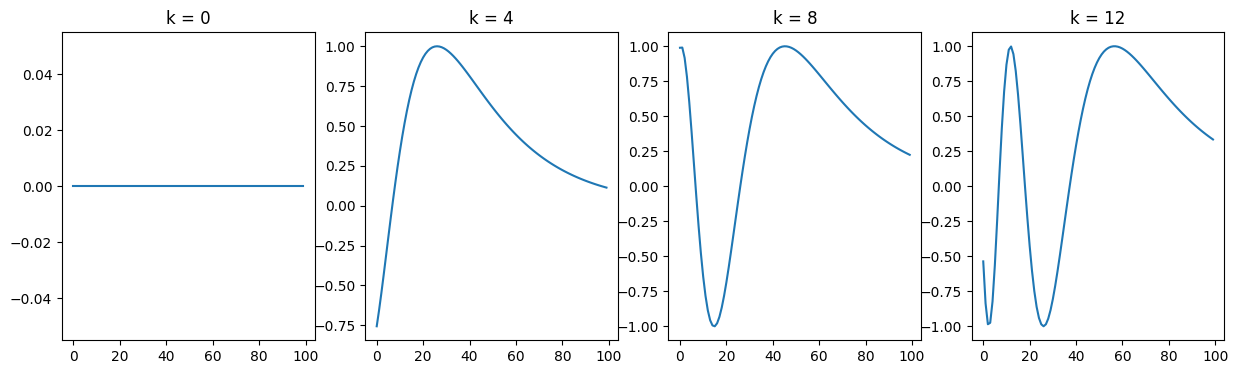

In [ ]:
def plotSinusoid(k, d=512, n=10000):
    x = np.arange(0, 100, 1)
    denominator = np.power(n, 2*x/d)
    y = np.sin(k/denominator)
    plt.plot(x, y)
    plt.title('k = ' + str(k))

fig = plt.figure(figsize=(15, 4))
for i in range(4):
    plt.subplot(141 + i)
    plotSinusoid(i*4)

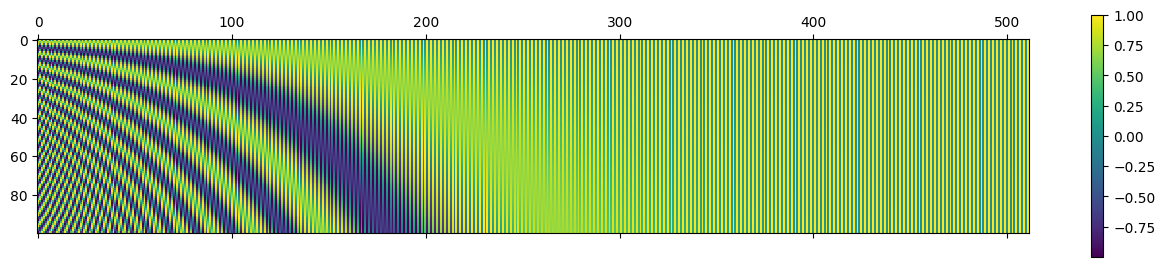

In [ ]:
P = getPositionEncoding(seq_len=100, d=512, n=10000)
cax = plt.matshow(P)
plt.gcf().colorbar(cax)

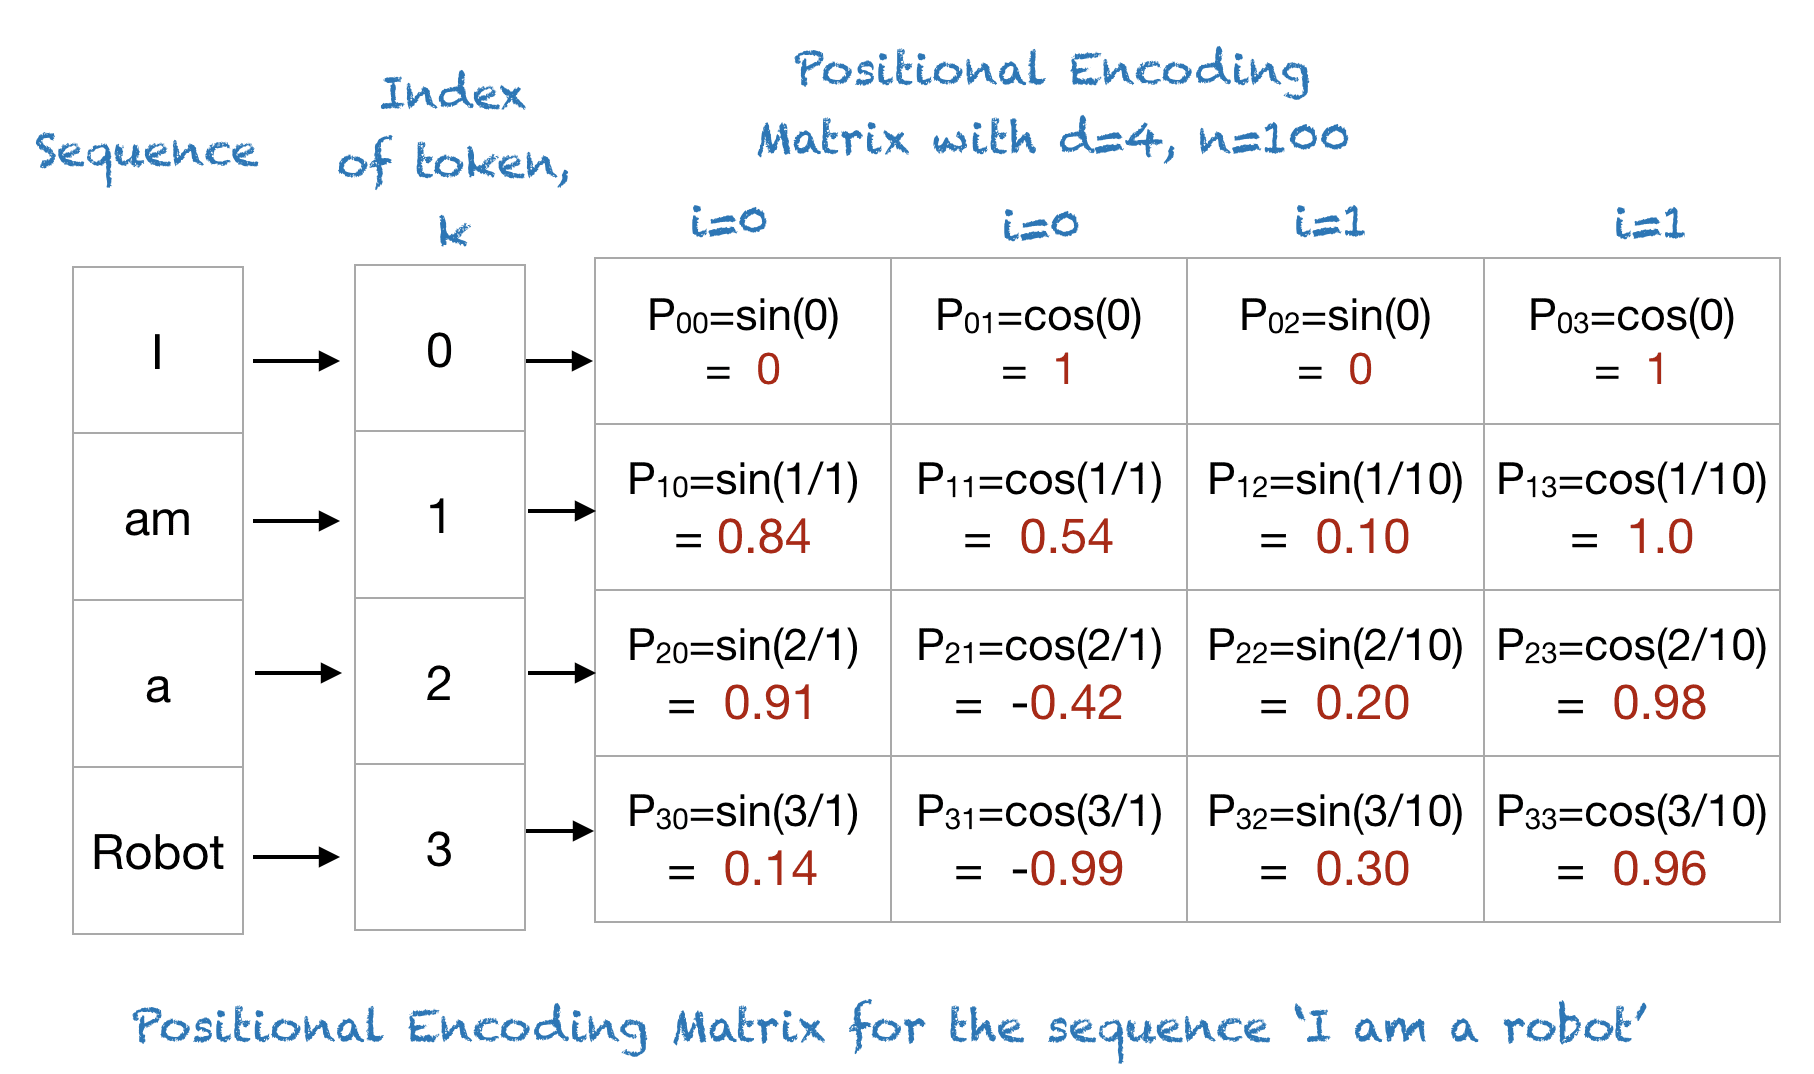